In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
from src.sdesim import *

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from tqdm.notebook import tqdm

In [14]:
# source: https://hautahi.com/sde_simulation
# SDE model parameters
mu, sigma, X0 = 2, 1, 1


str_err_em, str_err_mil, weak_err_em, weak_err_mil = [], [], [], []
dt_grid = [2 ** (R-10) for R in range(7)]
mc = 10000

# Loop over values of dt
for Dt in tqdm(dt_grid):
    
    # Setup discretized grid 
    t = np.arange(Dt, 1 + Dt, Dt)
    n = len(t)
    
    # Initiate vectors to store errors and time series
    err_em, err_mil = np.zeros(n), np.zeros(n)
    Y_sum, Xem_sum, Xmil_sum = np.zeros(n), np.zeros(n), np.zeros(n)
    
    # Generate many sample paths
    for i in tqdm(range(mc)):
        
        # Create Brownian Motion
        np.random.seed(i)
        dB = np.sqrt(Dt) * np.random.randn(n)
        B  = np.cumsum(dB)
        
        # Exact solution
        Y = X0 * np.exp((mu - 0.5*sigma**2)*t + sigma * B)
        
        # Simulate stochastic processes
        Xem = diffsim1dem(lambda x: mu*x, lambda x: sigma*x, X0, 1, Dt, i)
        Xmil = diffsim1dmil(lambda x: mu*x, lambda x: sigma*x, lambda x: sigma, X0, 1, Dt, i)

            
        # Compute strong errors and add to those across from other sample paths
        err_em  += abs(Y - Xem)
        err_mil += abs(Y - Xmil)
        
        # Add Y and X values to previous sample paths
        Y_sum += Y
        Xem_sum += Xem
        Xmil_sum += Xmil
        
    # Compute mean of absolute errors and find maximum (strong error)
    str_err_em.append(max(err_em / mc))
    str_err_mil.append(max(err_mil / mc))
    
    # Compute error of means and find maximum (weak error)
    weak_err_em.append(max(abs(Y_sum - Xem_sum)/mc))
    weak_err_mil.append(max(abs(Y_sum - Xmil_sum)/mc))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

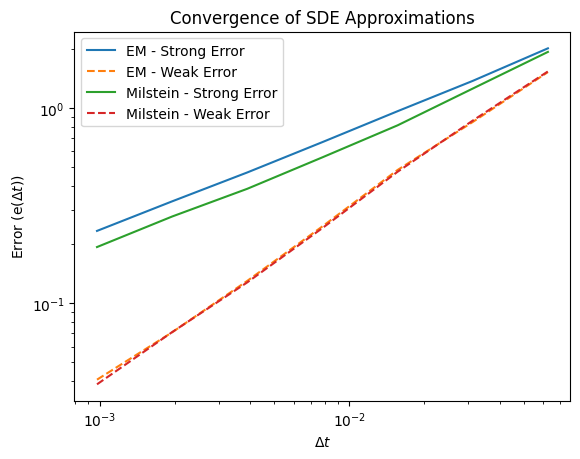

In [15]:
# Plot
plt.loglog(dt_grid, str_err_em, label="EM - Strong Error")
plt.loglog(dt_grid, weak_err_em, label="EM - Weak Error",ls='--')
plt.loglog(dt_grid, str_err_mil, label="Milstein - Strong Error")
plt.loglog(dt_grid, weak_err_mil, label="Milstein - Weak Error",ls='--')
plt.title('Convergence of SDE Approximations')
plt.xlabel('$\Delta t$'); plt.ylabel('Error (e($\Delta t$))'); plt.legend(loc=2);

In [16]:
import statsmodels.api as sm
X = sm.add_constant(np.log(dt_grid))

# Run OLS on above simulations to estimate gamma values
results = sm.OLS(np.log(weak_err_em),X).fit()
print("Weak E-M Convergence:        "+ str(results.params[1]))

results = sm.OLS(np.log(weak_err_mil),X).fit()
print("Weak Milstein Convergence:   "+ str(results.params[1]))

results = sm.OLS(np.log(str_err_em),X).fit()
print("\nStrong E-M Convergence:      "+ str(results.params[1]))

results = sm.OLS(np.log(str_err_mil),X).fit()
print("Strong Milstein Convergence: "+ str(results.params[1]))

Weak E-M Convergence:        0.8839797572949645
Weak Milstein Convergence:   0.8949875914094306

Strong E-M Convergence:      0.5166550087009634
Strong Milstein Convergence: 0.549979268892298
